1. In this second phase we are trying to perform detailed feature extraction for various different patterns and metrics to identify a skin disease.
2. we are trying to use mask rcnn to develop this knowing its capability of accurate feature extraction and instanc esegmentation

In [ ]:
#connect with drive to fetch data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/Data_ph2'

In [ ]:
import os
file_list = os.listdir(folder_path)
print(file_list)

['Test', 'Train', 'val']


In [ ]:
train_image_path = "/content/drive/MyDrive/Data_ph2/Train/ISIC2018_Task1-2_Training_Input"
train_mask_path = "/content/drive/MyDrive/Data_ph2/Train/ISIC2018_Task2_Training_GroundTruth_v3/ISIC2018_Task2_Training_GroundTruth_v3"

val_image_path = "/content/drive/MyDrive/Data_ph2/val/ISIC2018_Task1-2_Validation_Input"
val_mask_path = "/content/drive/MyDrive/Data_ph2/val/ISIC2018_Task2_Validation_GroundTruth/ISIC2018_Task2_Validation_GroundTruth"

test_image_path = "/content/drive/MyDrive/Data_ph2/Test/ISIC2018_Task1-2_Test_Input_n/ISIC2018_Task1-2_Test_Input"
test_mask_path = "/content/drive/MyDrive/Data_ph2/Test/ISIC2018_Task2_Test_GroundTruth/ISIC2018_Task2_Test_GroundTruth"

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [ ]:
def load_split_data(image_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []
    for image_name in os.listdir(image_dir):
        # Check file extension to only process JPEG or PNG files
        if image_name.endswith(('.jpeg', '.jpg', '.png')):
            # Load image
            img_path = os.path.join(image_dir, image_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            images.append(img)

            # Load corresponding masks
            image_id = image_name.split('.')[0]  # Extract base name
            mask = np.zeros((img_size[0], img_size[1], 5))  # 5 channels for 5 attributes
            for i, attr in enumerate(['pigment_network', 'negative_network', 'streaks', 'milia_like_cyst', 'globules']):
                mask_path = os.path.join(mask_dir, f"{image_id}_attribute_{attr}.png")
                if os.path.exists(mask_path):
                    m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    m = cv2.resize(m, img_size)
                    mask[:, :, i] = m / 255.0  # Normalize to 0-1
            masks.append(mask)
    return np.array(images), np.array(masks)

# Example Usage
train_images, train_masks = load_split_data(train_image_path, train_mask_path)
val_images, val_masks = load_split_data(val_image_path, val_mask_path)
test_images, test_masks = load_split_data(test_image_path, test_mask_path)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    Activation,
    UpSampling2D,
    Concatenate,
    GlobalAveragePooling2D,
    Reshape,
)
from tensorflow.keras.models import Model
import tensorflow as tf

def DeepLabV3Plus(input_shape, num_classes):
    # Load ResNet50 as the backbone
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(input_shape))

    # Encoder feature maps
    x = base_model.get_layer("conv4_block6_out").output  # Output stride 16, shape: (None, 16, 16, 1024)
    low_level_feature = base_model.get_layer("conv2_block3_out").output  # Output stride 4, shape: (None, 64, 64, 256)

    # ASPP Module
    # Apply atrous convolutions with different rates
    atrous_rates = [6, 12, 18]

    # 1x1 convolution branch
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False)(x)
    b0 = BatchNormalization()(b0)
    b0 = Activation('relu')(b0)

    # Atrous convolution branches
    b1 = Conv2D(256, (3, 3), padding='same', dilation_rate=atrous_rates[0], use_bias=False)(x)
    b1 = BatchNormalization()(b1)
    b1 = Activation('relu')(b1)

    b2 = Conv2D(256, (3, 3), padding='same', dilation_rate=atrous_rates[1], use_bias=False)(x)
    b2 = BatchNormalization()(b2)
    b2 = Activation('relu')(b2)

    b3 = Conv2D(256, (3, 3), padding='same', dilation_rate=atrous_rates[2], use_bias=False)(x)
    b3 = BatchNormalization()(b3)
    b3 = Activation('relu')(b3)

    # Image-level features
    b4 = GlobalAveragePooling2D()(x)
    b4 = Reshape((1, 1, x.shape[-1]))(b4)
    b4 = Conv2D(256, (1, 1), padding='same', use_bias=False)(b4)
    b4 = BatchNormalization()(b4)
    b4 = Activation('relu')(b4)
    b4 = UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation='bilinear')(b4)

    # Concatenate ASPP branches
    x = Concatenate()([b4, b0, b1, b2, b3])
    x = Conv2D(256, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Decoder
    # Upsample ASPP output to match low-level features' spatial dimensions
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # Upsampled to (None, 64, 64, 256)

    # Process low-level features
    low_level_feature = Conv2D(48, (1, 1), padding='same', use_bias=False)(low_level_feature)
    low_level_feature = BatchNormalization()(low_level_feature)
    low_level_feature = Activation('relu')(low_level_feature)

    # Concatenate
    x = Concatenate()([x, low_level_feature])  # Now x has shape (None, 64, 64, 304)

    # Final decoding convolutions
    x = Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsample to original image size
    x = UpSampling2D(size=(input_shape[0] // x.shape[1], input_shape[1] // x.shape[2]), interpolation='bilinear')(x)
    x = Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=x)

# Instantiate and compile the model
model = DeepLabV3Plus(input_shape=(256, 256, 3), num_classes=5)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 17,831,237 (68.02 MB)

 Trainable params: 17,796,453 (67.89 MB)

 Non-trainable params: 34,784 (135.88 KB)

In [ ]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(horizontal_flip=True, vertical_flip=True, rotation_range=90)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Data generator for training
def data_generator(images, masks, batch_size):
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=42)
    while True:
        yield next(image_generator), next(mask_generator)

batch_size = 8
train_gen = data_generator(train_images, train_masks, batch_size)
val_gen = (val_images, val_masks)  # No augmentation


In [ ]:
# Callbacks for better training

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=50,
    validation_data=val_gen,

)


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2594, 256, 256, 5) (5 channels).
  warnings.warn(


Epoch 1/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 161s 313ms/step - accuracy: 0.3315 - loss: 0.1107 - val_accuracy: 0.6806 - val_loss: 0.0404
Epoch 2/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 110s 264ms/step - accuracy: 0.6493 - loss: 0.0309 - val_accuracy: 0.6324 - val_loss: 0.0340
Epoch 3/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 86s 265ms/step - accuracy: 0.5878 - loss: 0.0294 - val_accuracy: 0.9867 - val_loss: 0.1229
Epoch 4/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 86s 265ms/step - accuracy: 0.7495 - loss: 0.0301 - val_accuracy: 0.9787 - val_loss: 0.0373
Epoch 5/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 86s 266ms/step - accuracy: 0.7712 - loss: 0.0294 - val_accuracy: 0.9549 - val_loss: 0.0366
Epoch 6/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 86s 268ms/step - accuracy: 0.7584 - loss: 0.0279 - val_accuracy: 0.9725 - val_loss: 0.0468
Epoch 7/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 86s 266ms/step - accuracy: 0.7127 - loss: 0.0286 - val_accuracy: 0.8986 - val_loss: 0.0342
Epoch 8/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 86s 267ms/step - accuracy: 0.7410 - loss:

In [ ]:
# Predict masks for test images
test_preds = model.predict(test_images)

# Compute Jaccard Index for each attribute
def jaccard_index(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return intersection / union

jaccard_scores = [jaccard_index(test_masks[..., i], test_preds[..., i]) for i in range(5)]
print("Jaccard Scores for Test Attributes:", jaccard_scores)


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step
Jaccard Scores for Test Attributes: [0.27259675853741205, 0.007260406697816978, 0.04427169388724221, 0.011691621983526263, 0.074936302693537]


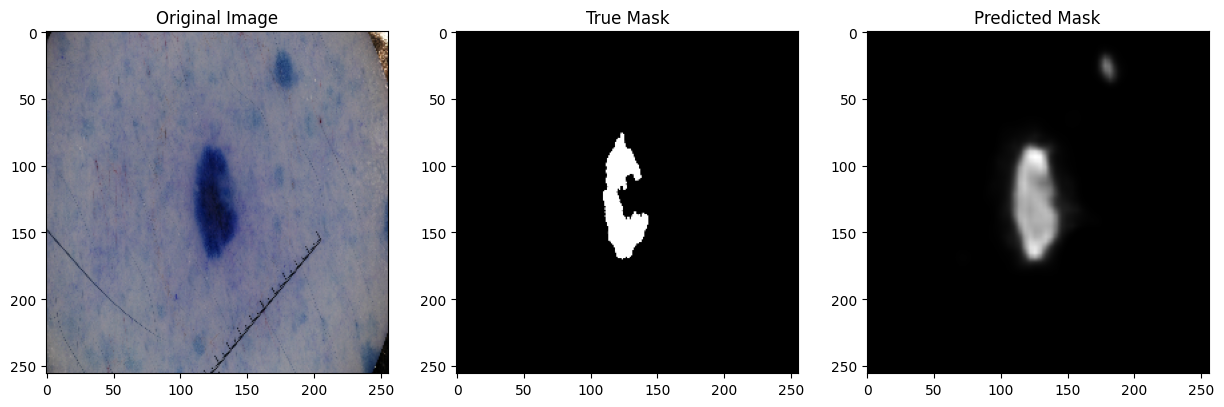

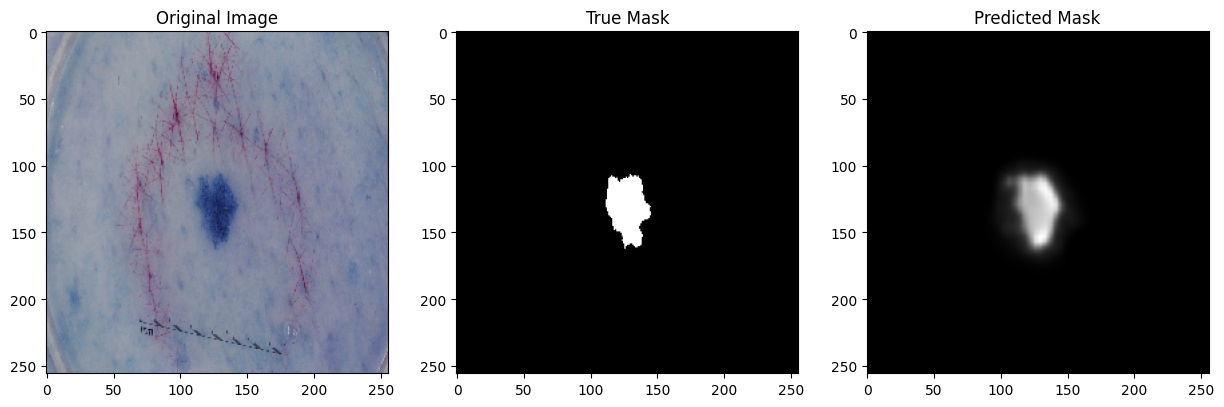

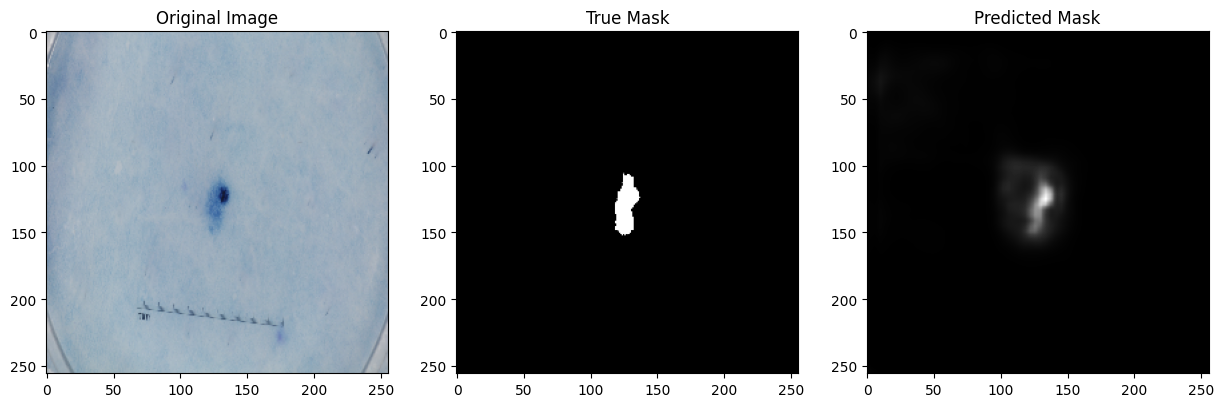

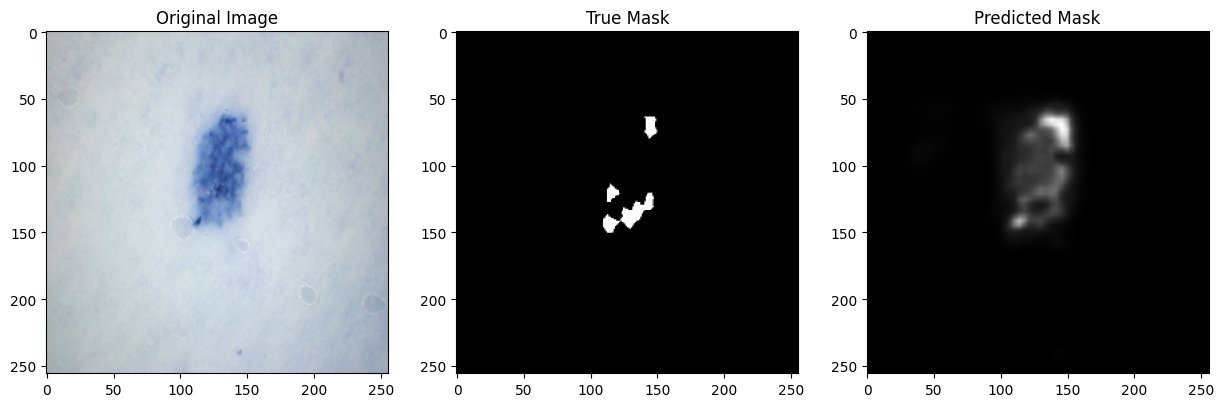

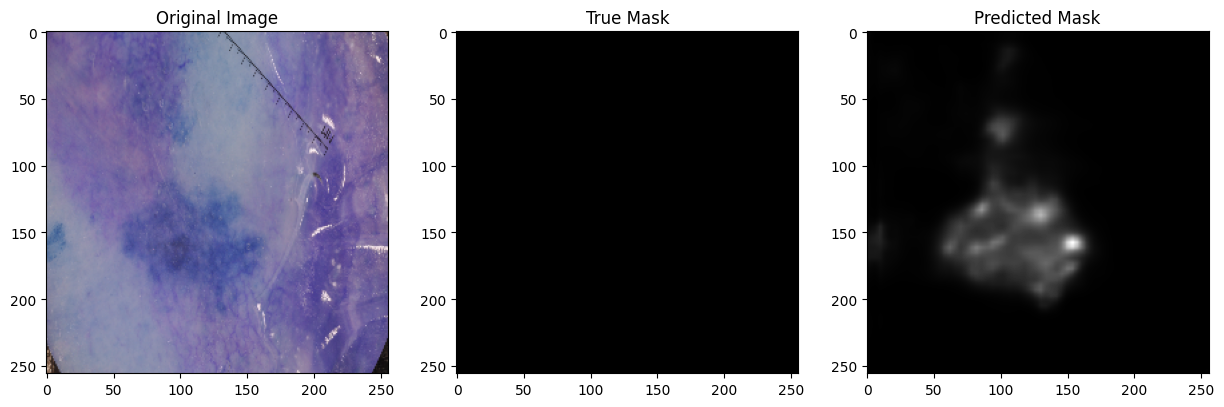

In [ ]:
# Visualize predictions
def visualize_predictions(images, true_masks, pred_masks, index):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(images[index])
    plt.title("Original Image")

    # True Masks (Combine all channels for visualization)
    plt.subplot(1, 3, 2)
    plt.imshow(np.sum(true_masks[index], axis=-1), cmap="gray")
    plt.title("True Mask")

    # Predicted Masks
    plt.subplot(1, 3, 3)
    plt.imshow(np.sum(pred_masks[index], axis=-1), cmap="gray")
    plt.title("Predicted Mask")

    plt.show()

# Visualize a few test predictions
for i in range(5):  # Change range for more examples
    visualize_predictions(test_images, test_masks, test_preds, i)
